In [1]:
# util imports
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from skimage.io import imread
from skimage.color import rgba2rgb
import shutil
import time

# audio loading, analysis and preprocessing imports
from IPython.display import Audio 
from IPython.display import display
import librosa
from librosa.core.spectrum import stft
from pydub import AudioSegment
import pylab
from scipy import signal
import wav

# neural network imports
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras import layers
from keras.applications import ResNet50V2
from keras.models import Sequential
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout


# get sound path by audio id
def soundPath(id):
    return f'/kaggle/input/bird-voice-detection/ff1010bird_wav/wav/{id}.wav'

# play sound
def play_sound(path, autoplay=False):
    display(Audio(path, autoplay=autoplay))

# wav to amplitude array
def wav_to_array(path):
    spf = wave.open(path, "r")
    if spf.getnchannels() == 2:
        print("Just mono files")
        return None
    signal = spf.readframes(16000)
    signal = np.frombuffer(signal, dtype = np.int_)
    return signal

# plot audio wave
def plot_wave(path):
    signal = wav_to_array(path)
    plt.figure(1)
    plt.title("Signal Wave...")
    plt.plot(signal)
    plt.show()

# func for play and plot
def play_and_plot(path, autoplay = False):
    play_sound(path, autoplay)
    plot_wave(path)

# another func for audio plot    
def soundwave(path):
    
    play_sound(path)
    
    signal_wave = wave.open(path, 'r')
    sample_rate = -1
    sig = np.frombuffer(signal_wave.readframes(sample_rate), dtype=np.int16)

    plt.figure(figsize=(12,12))
    plot_a = plt.subplot(211)
    plot_a.set_title(path)
    plot_a.plot(sig)
    plot_a.set_xlabel('sample rate * time')
    plot_a.set_ylabel('energy')

    plot_b = plt.subplot(212)
    plot_b.specgram(sig, NFFT=1024, Fs=sample_rate, noverlap=900)
    plot_b.set_xlabel('Time')
    plot_b.set_ylabel('Frequency')

    plt.show()

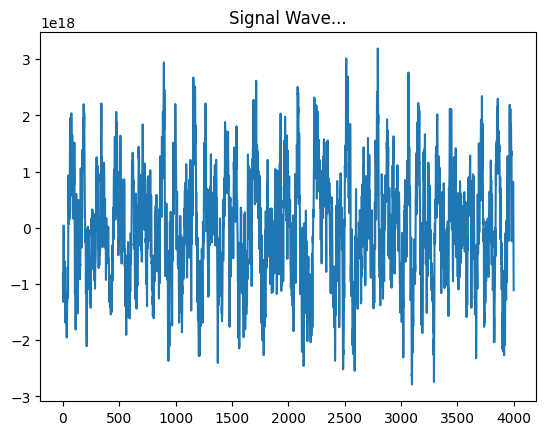

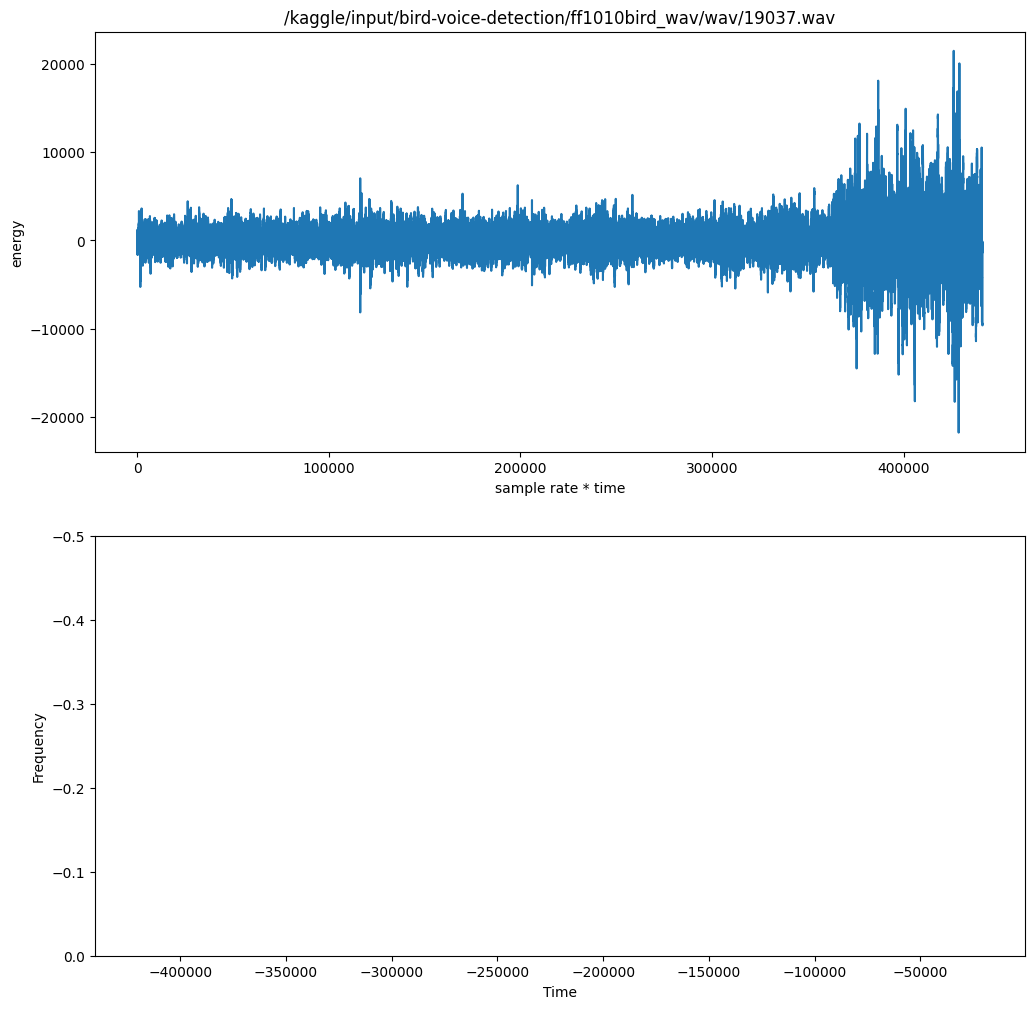

In [32]:
play_and_plot(soundPath(378), autoplay=True)
soundwave(soundPath(19037))

In [19]:
def resNet(is_frozen):
  resnet = ResNet50V2(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

  if is_frozen:
    for layer in resnet.layers:
        layer.trainable = False

  return Sequential([
      resnet,
      layers.GlobalAveragePooling2D(),
      Dense(1, activation='sigmoid')
  ])

In [21]:
frozen_resNet = resNet(True)
frozen_resNet.compile(loss='binary_crossentropy' ,optimizer='adam', metrics = ['accuracy'])
history_frozen_resnet = frozen_resNet.fit(train_dataset, epochs=30, validation_data=valid_dataset)

Epoch 1/30
48/48 [==============================] - 33s 577ms/step - loss: 6.1976 - accuracy: 0.5564 - val_loss: 2.5840 - val_accuracy: 0.4828
Epoch 2/30
48/48 [==============================] - 28s 538ms/step - loss: 1.6331 - accuracy: 0.6146 - val_loss: 1.3078 - val_accuracy: 0.6392
Epoch 3/30
48/48 [==============================] - 28s 528ms/step - loss: 1.2933 - accuracy: 0.6437 - val_loss: 1.1718 - val_accuracy: 0.6484
Epoch 4/30
48/48 [==============================] - 30s 559ms/step - loss: 1.2325 - accuracy: 0.6528 - val_loss: 1.1189 - val_accuracy: 0.6911
Epoch 5/30
48/48 [==============================] - 29s 540ms/step - loss: 1.2084 - accuracy: 0.6568 - val_loss: 1.4421 - val_accuracy: 0.6873
Epoch 6/30
48/48 [==============================] - 29s 541ms/step - loss: 1.0254 - accuracy: 0.6767 - val_loss: 1.0423 - val_accuracy: 0.6453
Epoch 7/30
48/48 [==============================] - 29s 546ms/step - loss: 1.0075 - accuracy: 0.6875 - val_loss: 1.4836 - val_accuracy: 0.5507

In [27]:
tuned_resNet = resNet(False)
tuned_resNet.compile(loss='binary_crossentropy' ,optimizer='adam', metrics = ['accuracy'])
history_tuned_resnet = tuned_resNet.fit(train_dataset, epochs=30, validation_data=valid_dataset)

Epoch 1/30
48/48 [==============================] - 81s 1s/step - loss: 0.5472 - accuracy: 0.7375 - val_loss: 336.2197 - val_accuracy: 0.4371
Epoch 2/30
48/48 [==============================] - 47s 916ms/step - loss: 0.4531 - accuracy: 0.7954 - val_loss: 81.5218 - val_accuracy: 0.5614
Epoch 3/30
48/48 [==============================] - 47s 928ms/step - loss: 0.4072 - accuracy: 0.8238 - val_loss: 4.9601 - val_accuracy: 0.5721
Epoch 4/30
48/48 [==============================] - 47s 920ms/step - loss: 0.3906 - accuracy: 0.8280 - val_loss: 3.3087 - val_accuracy: 0.5019
Epoch 5/30
48/48 [==============================] - 47s 931ms/step - loss: 0.3437 - accuracy: 0.8607 - val_loss: 3.4339 - val_accuracy: 0.5927
Epoch 6/30
48/48 [==============================] - 47s 918ms/step - loss: 0.3315 - accuracy: 0.8581 - val_loss: 0.5793 - val_accuracy: 0.7719
Epoch 7/30
48/48 [==============================] - 47s 932ms/step - loss: 0.2883 - accuracy: 0.8820 - val_loss: 21.9774 - val_accuracy: 0.460

In [4]:
def spectro(id, positive, high_freq = False):    
    plt.rcParams["figure.figsize"] = [7.50, 3.50]
    plt.rcParams["figure.autolayout"] = True

    #fig, ax = plt.subplots()

    hl = 512 # number of samples per time-step in spectrogram
    hi = 256 # Height of image
    wi = 256 # Width of image

    # Loading demo track
    y, sr = librosa.load(soundPath(id))
    
    def get_high_freq(y, sr):
        b,a = signal.butter(10, 2000/(sr/2), btype='highpass')
        yf = signal.lfilter(b,a,y)
        return yf
    
    if high_freq:
        y = get_high_freq(y, sr)
    
    window = y[0:wi*hl]

    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=hi, hop_length=hl)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr)
    #plt.axis('off')
    plt.colorbar()
    #plt.show()
    
#     dest_folder = 'positive' if positive else 'negative'
    
#     if not os.path.exists(f'/kaggle/working/spectrograms/'):
#         os.mkdir(f'/kaggle/working/spectrograms')
    
#     if not os.path.exists(f'/kaggle/working/spectrograms/{method}'):
#         os.mkdir(f'/kaggle/working/spectrograms/{method}')

#     if not os.path.exists(f'/kaggle/working/spectrograms/{method}/{dest_folder}'):
#         os.mkdir(f'/kaggle/working/spectrograms/{method}/{dest_folder}')

#     plt.savefig(f'/kaggle/working/spectrograms/{method}/{dest_folder}/{id}.png', bbox_inches='tight', pad_inches=0)
#     plt.close()
#spectro(19037, True, True)

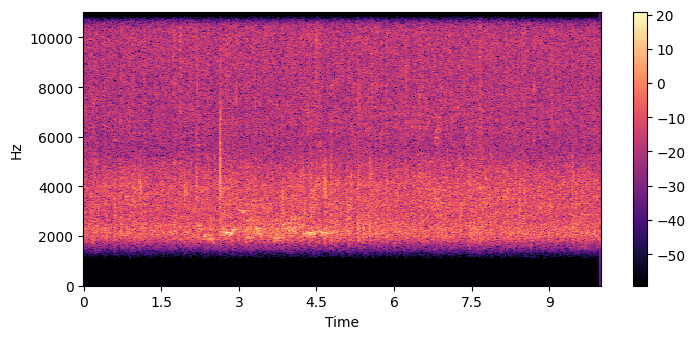

In [14]:
import gc

def spectro_stft(id, positive, high_freq):
    plt.rcParams["figure.figsize"] = [7.50, 3.50]
    plt.rcParams["figure.autolayout"] = True
    y, sr = librosa.load(soundPath(id))
    
    def get_high_freq(y, sr):
        b,a = signal.butter(10, 2000/(sr/2), btype='highpass')
        yf = signal.lfilter(b,a,y)
        return yf
    
    if high_freq:
        y = get_high_freq(y, sr)
    S = librosa.stft(y)
    S_dB = librosa.amplitude_to_db(abs(S))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='hz')
#     plt.axis('off')
    plt.colorbar()
    dest_folder = 'positive' if positive else 'negative'
    
#     if not os.path.exists(f'/kaggle/working/stft_spectrograms/'):
#         os.mkdir(f'/kaggle/working/stft_spectrograms')
    
# #     if not os.path.exists(f'/kaggle/working/spectrograms/stft'):
# #         os.mkdir(f'/kaggle/working/spectrograms/stft')

#     if not os.path.exists(f'/kaggle/working/stft_spectrograms/{dest_folder}'):
#         os.mkdir(f'/kaggle/working/stft_spectrograms/{dest_folder}')

    #plt.savefig(f'/kaggle/working/stft_spectrograms/{dest_folder}/{id}.png', bbox_inches='tight', pad_inches=0)
    plt.show()

# def get_stft_spectro(n, positive, high_freq):
#     df = pd.read_csv('/kaggle/input/bird-voice-detection/metadata.csv')
#     df = df.loc[df['label']==1] if positive else df.loc[df['label']==0]
#     i=1
#     for id in df['id']:
#         dest_path = f'/kaggle/working/stft_spectrograms/positive/{id}.png' if positive else f'/kaggle/working/stft_spectrograms/negative/{id}.png'
#         if not os.path.exists(dest_path):
#             spectro_stft(id, positive, high_freq)
#             i+=1
#             gc.collect()
#         if i > n:
#             return

# get_stft_spectro(500, False, True)
spectro_stft(19037, True, True)

In [ ]:
def get_spectrograms(n, positive, method, high_freq):
    df = pd.read_csv('/kaggle/input/bird-voice-detection/metadata.csv')

    df = df.loc[df['label']==1] if positive else df.loc[df['label']==0]
    i=1
    for id in df['id']:
        dest_path = f'/kaggle/working/spectrograms/{method}/positive/{id}.png' if positive else f'/kaggle/working/spectrograms/{method}/negative/{id}.png'
        if not os.path.exists(dest_path):
            spectro(id, positive, method, high_freq)
            i+=1
        if i > n:
            return

#get_spectrograms(1700, True, 'high_freq', True)
get_spectrograms(435, False, 'high_freq', True)


In [7]:
def count_files(path):
  print(len(os.listdir(path)))

count_files('/kaggle/working/spectrograms/high_freq/negative')

2435


In [8]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=64,
                                             validation_split=0.3,
                                             directory='/kaggle/working/spectrograms/high_freq',
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(256, 256),
                                             subset="training",
                                             seed=102)

valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=64,
                                             validation_split=0.3,
                                             directory='/kaggle/working/spectrograms/high_freq',
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(256, 256),
                                             subset="validation",
                                             seed = 102)

Found 4370 files belonging to 2 classes.
Using 3059 files for training.
Found 4370 files belonging to 2 classes.
Using 1311 files for validation.


In [26]:
def clear_output_folder():
    shutil.rmtree('/kaggle/working/spectrograms/positive')

clear_output_folder()

In [58]:
def createCNN():
    return Sequential([
    Input(shape=(256, 256, 3)),
    #layer 1
    Conv2D(32, 3, strides=2, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    # layer 2
    Conv2D(64, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    # layer 3
    Conv2D(128, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    # layer 4
    Conv2D(256, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    #layer 5
    Conv2D(512, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    #layer 6
    Conv2D(1024, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    # layer 7
    Conv2D(2048, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
    ])

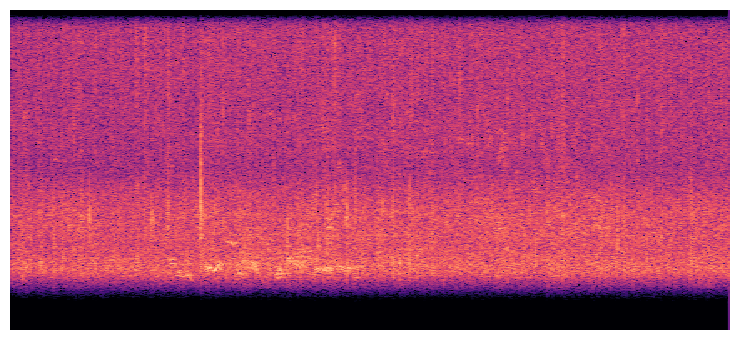

In [7]:
from skimage.io import imread
img = imread('/kaggle/working/stft_spectrograms/positive/19037.png')
plt.axis('off')
plt.imshow(img)
plt.show()

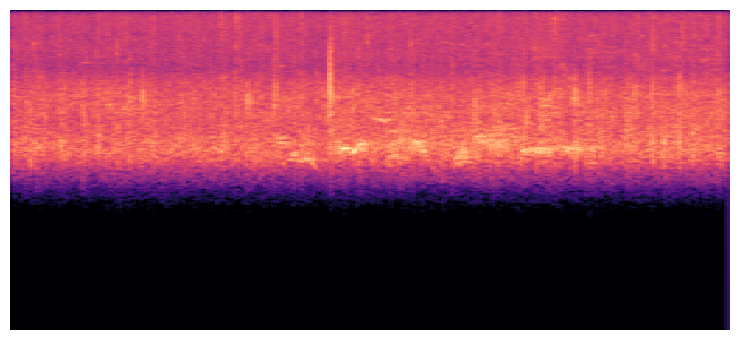

In [9]:
img = imread('/kaggle/working/spectrograms/high_freq/positive/19037.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [41]:
    cnn1 = createCNN()
    #cnn.compile(loss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) ,optimizer='adam', metrics = ['accuracy'] )
    cnn1.compile(loss='binary_crossentropy' ,optimizer='adam', metrics = ['accuracy'] )
    history_cnn1 = cnn1.fit(x=train_dataset, 
                      epochs = 30,
                      validation_data=valid_dataset)

Epoch 1/30
48/48 [==============================] - 30s 508ms/step - loss: 0.7514 - accuracy: 0.6277 - val_loss: 25.5861 - val_accuracy: 0.6011
Epoch 2/30
48/48 [==============================] - 28s 532ms/step - loss: 0.6079 - accuracy: 0.7025 - val_loss: 1.8412 - val_accuracy: 0.6362
Epoch 3/30
48/48 [==============================] - 28s 528ms/step - loss: 0.5050 - accuracy: 0.7643 - val_loss: 0.5627 - val_accuracy: 0.7338
Epoch 4/30
48/48 [==============================] - 24s 459ms/step - loss: 0.4122 - accuracy: 0.8215 - val_loss: 0.5955 - val_accuracy: 0.7040
Epoch 5/30
48/48 [==============================] - 27s 515ms/step - loss: 0.2899 - accuracy: 0.8830 - val_loss: 0.6906 - val_accuracy: 0.6407
Epoch 6/30
48/48 [==============================] - 27s 512ms/step - loss: 0.1744 - accuracy: 0.9448 - val_loss: 0.5726 - val_accuracy: 0.7147
Epoch 7/30
48/48 [==============================] - 28s 530ms/step - loss: 0.1129 - accuracy: 0.9703 - val_loss: 0.7351 - val_accuracy: 0.624

In [11]:
    cnn3 = createCNN()
    cnn3.compile(loss='binary_crossentropy' ,optimizer='adam', metrics = ['accuracy'] )
    history_adam = cnn3.fit(x=train_dataset, 
                      epochs = 30,
                      validation_data=valid_dataset)

Epoch 1/30
48/48 [==============================] - 42s 490ms/step - loss: 0.7620 - accuracy: 0.6538 - val_loss: 0.8662 - val_accuracy: 0.6629
Epoch 2/30
48/48 [==============================] - 27s 522ms/step - loss: 0.6475 - accuracy: 0.6921 - val_loss: 1.9512 - val_accuracy: 0.5675
Epoch 3/30
48/48 [==============================] - 28s 522ms/step - loss: 0.6155 - accuracy: 0.7006 - val_loss: 1.5342 - val_accuracy: 0.5721
Epoch 4/30
48/48 [==============================] - 25s 466ms/step - loss: 0.5874 - accuracy: 0.7136 - val_loss: 0.9615 - val_accuracy: 0.4828
Epoch 5/30
48/48 [==============================] - 25s 470ms/step - loss: 0.5423 - accuracy: 0.7408 - val_loss: 0.5974 - val_accuracy: 0.7040
Epoch 6/30
48/48 [==============================] - 27s 523ms/step - loss: 0.5287 - accuracy: 0.7444 - val_loss: 0.5663 - val_accuracy: 0.7422
Epoch 7/30
48/48 [==============================] - 25s 472ms/step - loss: 0.4982 - accuracy: 0.7650 - val_loss: 0.5535 - val_accuracy: 0.6941

In [53]:
    cnn_stft = createCNN()
    #cnn.compile(loss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) ,optimizer='adam', metrics = ['accuracy'] )
    cnn_stft.compile(loss='binary_crossentropy' ,optimizer='adam', metrics = ['accuracy'] )
    history_adam_stft = cnn_stft.fit(x=train_dataset, 
                      epochs = 1,
                      validation_data=valid_dataset)

25/25 [==============================] - 16s 360ms/step - loss: 1.0111 - accuracy: 0.5575 - val_loss: 5.7840 - val_accuracy: 0.4900


In [59]:
cnn7 = createCNN()
cnn7.compile(loss='binary_crossentropy' ,optimizer='adam', metrics = ['accuracy'] )
history_cnn7 = cnn7.fit(x=train_dataset, 
                      epochs = 30,
                      validation_data=valid_dataset)

Epoch 1/30
48/48 [==============================] - 38s 528ms/step - loss: 0.8421 - accuracy: 0.6267 - val_loss: 1.1144 - val_accuracy: 0.6705
Epoch 2/30
48/48 [==============================] - 26s 484ms/step - loss: 0.6618 - accuracy: 0.6894 - val_loss: 0.9452 - val_accuracy: 0.6583
Epoch 3/30
48/48 [==============================] - 25s 465ms/step - loss: 0.6278 - accuracy: 0.6986 - val_loss: 0.8035 - val_accuracy: 0.5484
Epoch 4/30
48/48 [==============================] - 25s 479ms/step - loss: 0.5912 - accuracy: 0.7198 - val_loss: 1.7205 - val_accuracy: 0.5050
Epoch 5/30
48/48 [==============================] - 25s 478ms/step - loss: 0.5924 - accuracy: 0.7287 - val_loss: 1.6768 - val_accuracy: 0.4683
Epoch 6/30
48/48 [==============================] - 26s 473ms/step - loss: 0.5419 - accuracy: 0.7460 - val_loss: 0.5031 - val_accuracy: 0.7712
Epoch 7/30
48/48 [==============================] - 26s 482ms/step - loss: 0.5246 - accuracy: 0.7627 - val_loss: 0.5054 - val_accuracy: 0.7635

In [ ]:
print(cnn.summary())

In [60]:
result = cnn7.evaluate(valid_dataset, verbose = 0)
print(dict(zip(cnn.metrics_names, result)))

# result = cnn_rms.evaluate(valid_dataset)
# print(dict(zip(cnn_rms.metrics_names, result)))

{'loss': 0.9268914461135864, 'accuracy': 0.7643020749092102}


In [13]:
def plot_metrics(history, model_name):
    def loss():
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train loss', 'val loss'], loc='upper right')
        plt.title(model_name + ' loss')
        plt.show()

    def accuracy():
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train accuracy', 'val accuracy'], loc='upper right')
        plt.title(model_name + ' accuracy')
        plt.show()

    loss()
    accuracy()

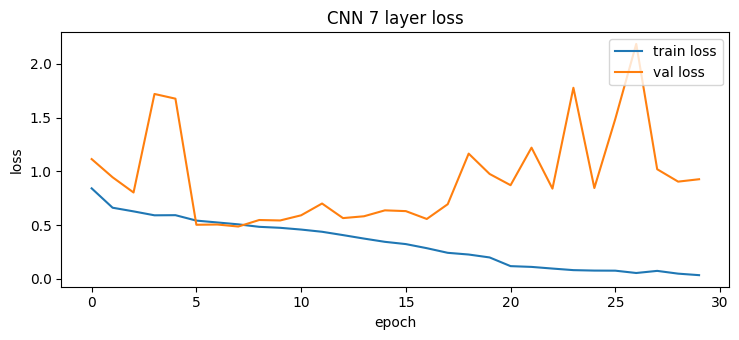

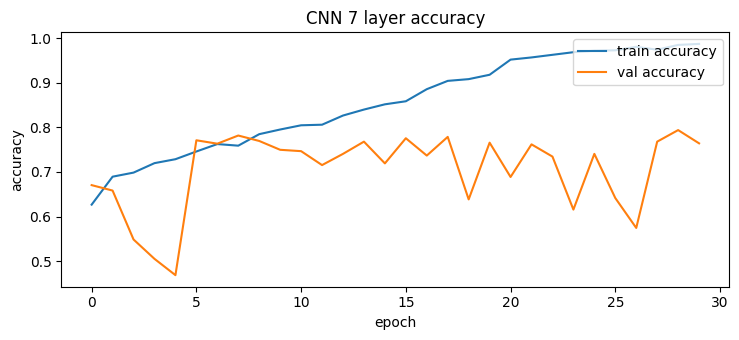

In [61]:
plot_metrics(history_cnn7, 'CNN 7 layer')

In [62]:
from tensorflow.keras.models import model_from_json

def export_model(model, name):
    model_json = model.to_json()
    with open(f"{name}.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f"{name}.h5")
    print(f"Saved model '{name}' to disk")

def import_model(path):
    json_file = open(f'{path}.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(f"{path}.h5")
    print(f"Loaded model '{path}' from disk")
    return loaded_model

export_model(cnn7,'cnn7')
#cnn = import_model('cnn')
#cnn.compile(loss='binary_crossentropy' ,optimizer='Adam', metrics = ['accuracy'] )

Saved model 'cnn7' to disk


In [36]:
def predict_audio(id, model, high_freq):
    plt.rcParams["figure.figsize"] = [7.50, 3.50]
    plt.rcParams["figure.autolayout"] = True
    fig, ax = plt.subplots()
    hl = 512 # number of samples per time-step in spectrogram
    hi = 256 # Height of image
    wi = 256 # Width of image
    y, sr = librosa.load(soundPath(id))
    
    def get_high_freq(y, sr):
        b,a = signal.butter(10, 2000/(sr/2), btype='highpass')
        yf = signal.lfilter(b,a,y)
        return yf
    
    if high_freq:
        y = get_high_freq(y, sr)
    
    window = y[0:wi*hl]
    S = librosa.feature.melspectrogram(y=window, sr=sr, n_mels=hi, hop_length=hl)
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, ax=ax)
    
    if not os.path.exists('/kaggle/working/to_predict'):
        os.mkdir('/kaggle/working/to_predict')
    
    plt.axis('off')
    plt.savefig(f'/kaggle/working/to_predict/{id}.png', bbox_inches='tight', pad_inches=0)
    plt.close()
    
    image = tf.keras.utils.load_img(path=f'/kaggle/working/to_predict/{id}.png', target_size = (256,256), interpolation = 'bilinear')
    input_arr = tf.keras.utils.img_to_array(image)
    input_arr = np.array([input_arr])
    y_pred = model.predict(input_arr)
    
    y_pred = int(np.round(y_pred[0][0]))
    
    return y_pred

#predict_audio(111092, cnn, True)

SyntaxError: incomplete input (1260022130.py, line 1)

1
1/1 [==============================] - 10s 10s/step


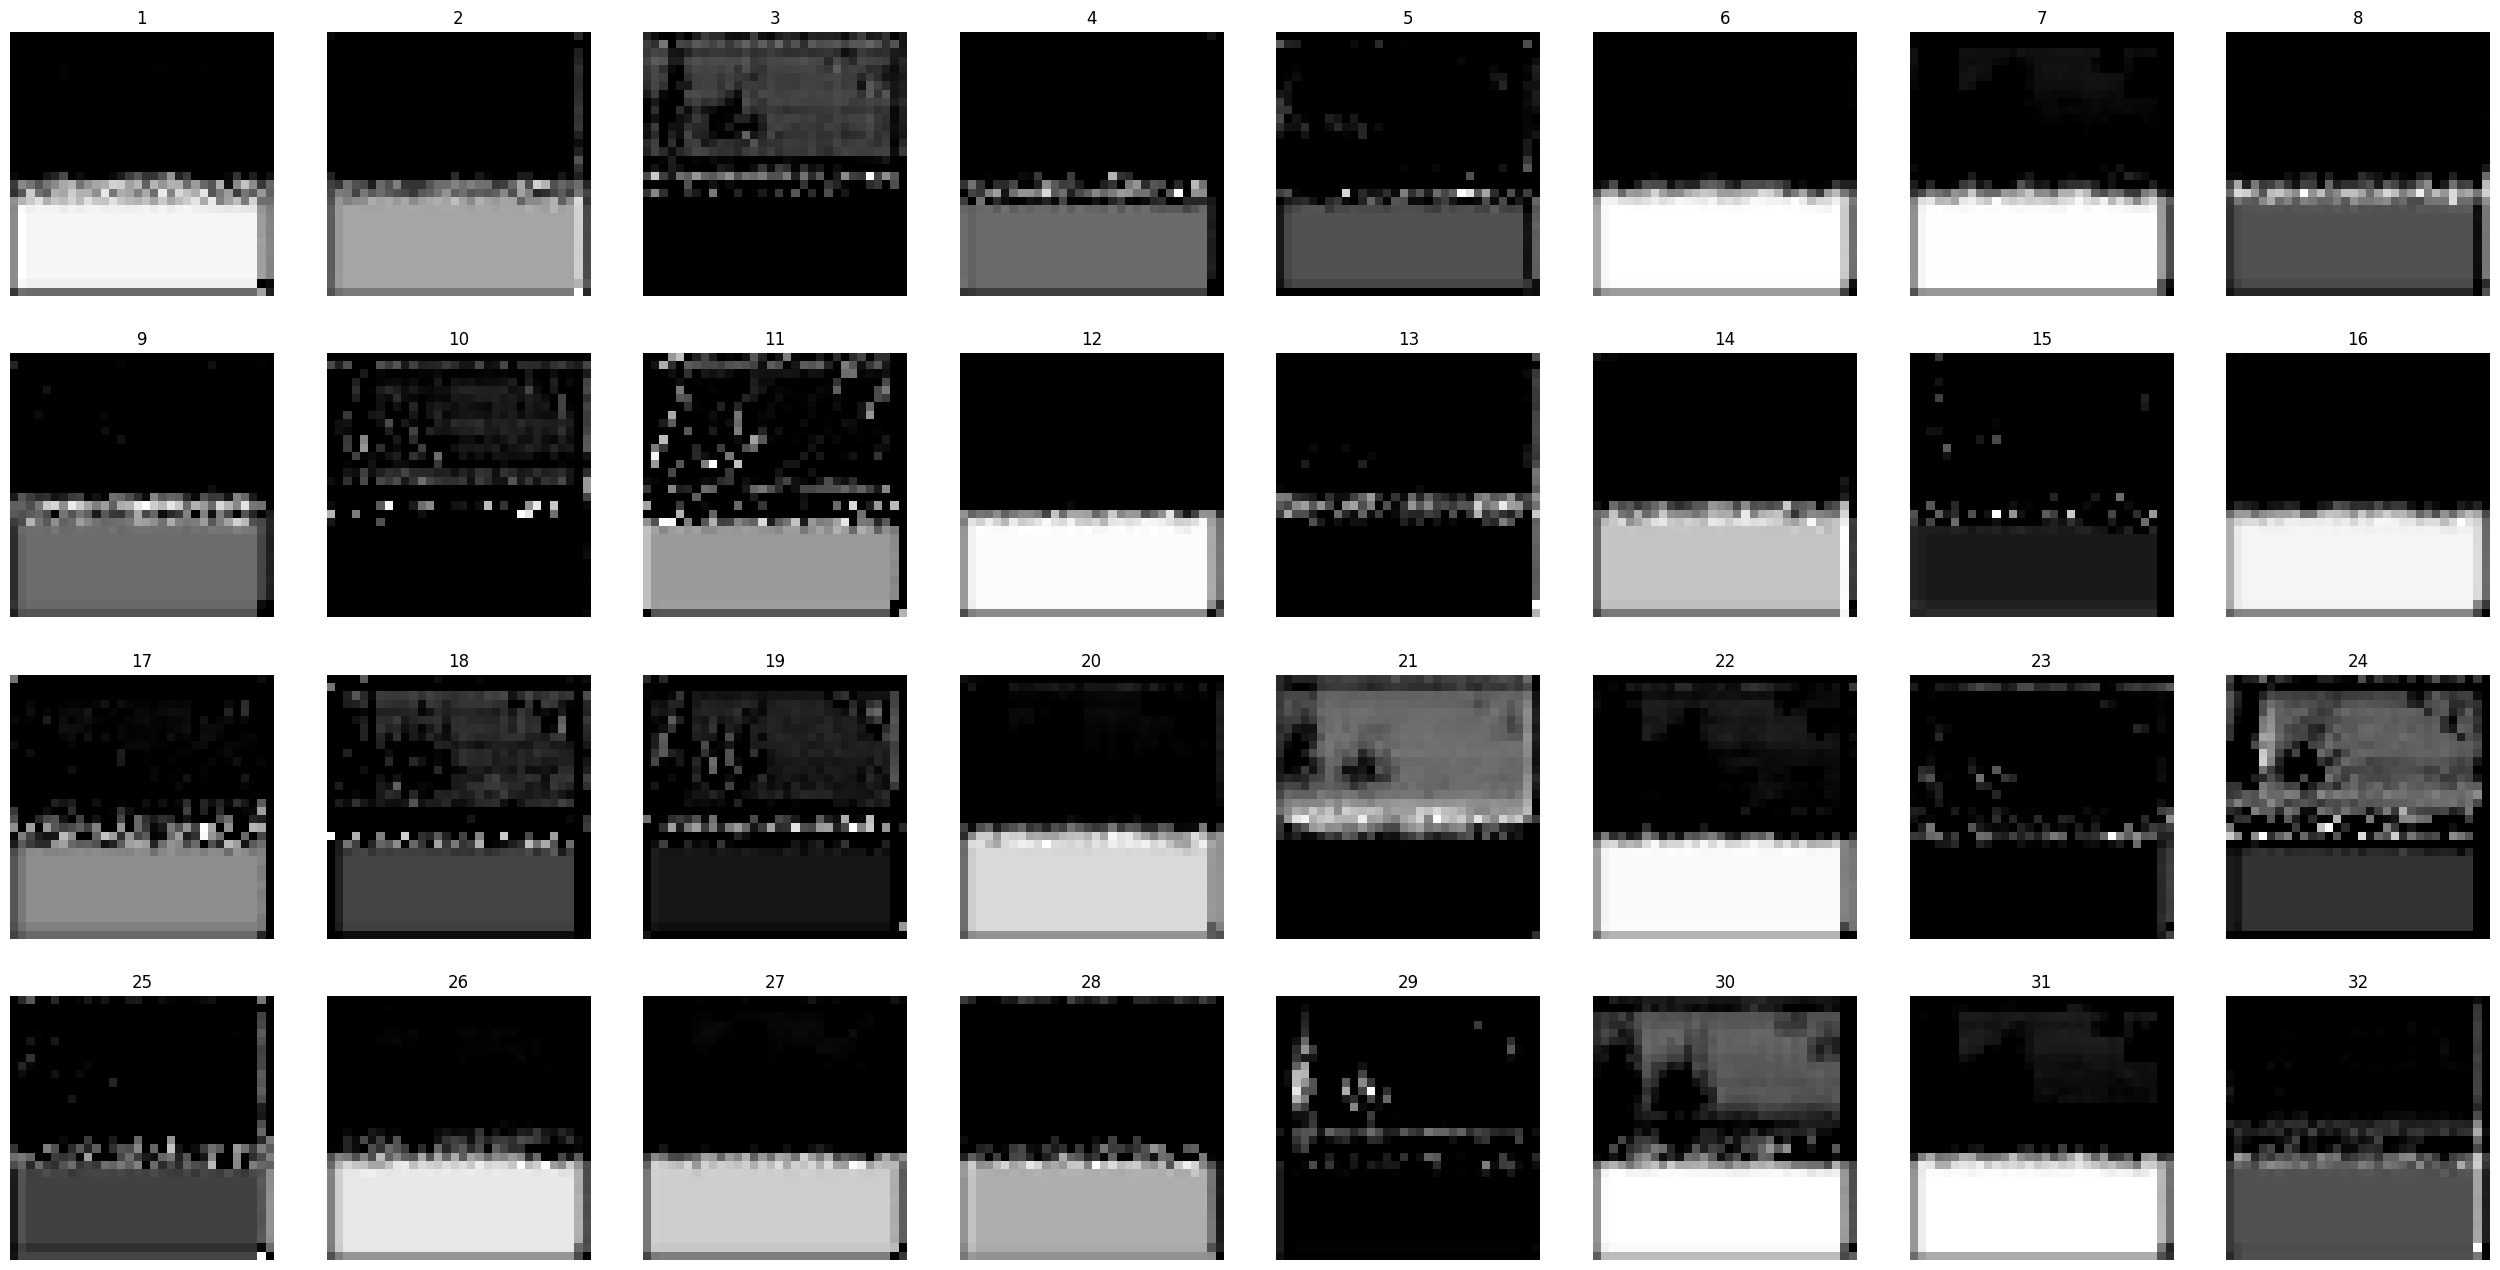

In [8]:
from keras.models import Model
import time
def plot_feature_map(id):
    df = pd.read_csv('/kaggle/input/bird-voice-detection/metadata.csv')
    
    image = tf.keras.utils.load_img(path=f'/kaggle/working/spectrograms/high_freq/positive/{id}.png', target_size = (256,256), interpolation = 'bilinear')
    input_arr = tf.keras.utils.img_to_array(image)
    input_arr = np.array([input_arr])
    
    label = df.loc[df['id']==id].iloc[0]['label']
    print(label)
    
    layer_1 = cnn.layers[0].output
    layer_2 = cnn.layers[4].output
    layer_3 = cnn.layers[8].output
    
    model = Model(inputs = cnn.input, outputs = [layer_1, layer_2,layer_3])
    layer_1, layer_2 ,layer_3= model.predict(input_arr)
    
    fig,axes = plt.subplots(4,8, figsize = (32,16))
    for i in range(32):
      ax = axes[i // 8, i % 8]
      ax.imshow(layer_3[0,:,:,i], cmap='gray')
      ax.axis('off')
      ax.set_title(i+1)
    plt.show()

plot_feature_map(111092)

In [93]:
y_pred = cnn.predict(valid_dataset)
#print(y_pred)
for i in range(len(y_pred)):
    y_pred[i] = np.round(y_pred[i][0])

print(len(y_pred))

28/28 [==============================] - 5s 134ms/step
874


In [8]:
from sklearn.metrics import f1_score

predictions = []
labels =  []
for x, y in valid_dataset:
    #predictions = np.concatenate([predictions, cnn.predict(x)])
    batch = tuned_resNet.predict(x)
    y = y.numpy()
    for i in range(len(batch)):
        predictions.append(np.round(batch[i][0]))
        labels.append(y[i])
    
print(len(predictions))
print(len(labels))

print(f1_score(labels, predictions))

1/1 [==============================] - 0s 156ms/step
1311
1311
0.6358267716535433


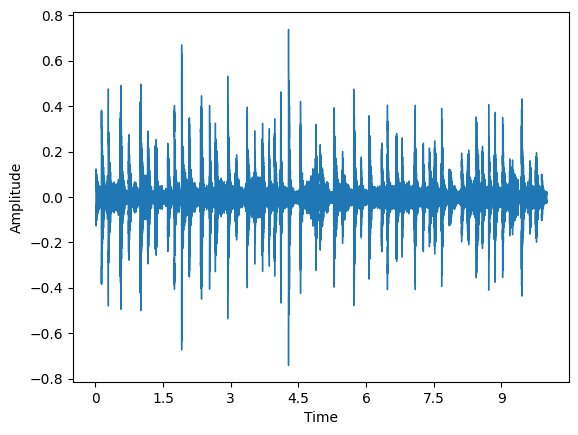

In [4]:
from librosa.display import waveshow
y, sr = librosa.load(soundPath(19992))
waveshow(y, sr=sr)
plt.ylabel("Amplitude")
plt.show()

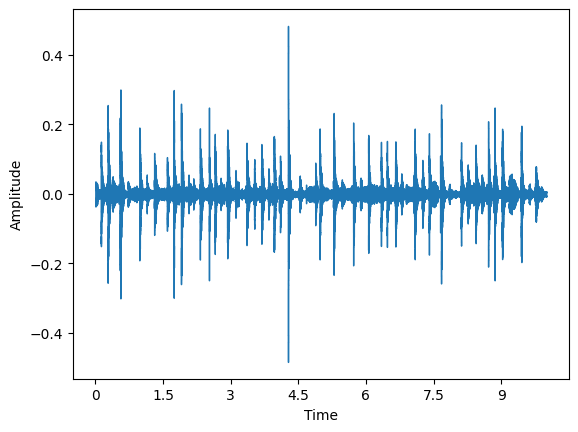

In [5]:
def get_high_freq(y, sr):
        b,a = signal.butter(10, 2000/(sr/2), btype='highpass')
        yf = signal.lfilter(b,a,y)
        return yf
y = get_high_freq(y, sr)
waveshow(y, sr=sr)
plt.ylabel("Amplitude")
plt.show()

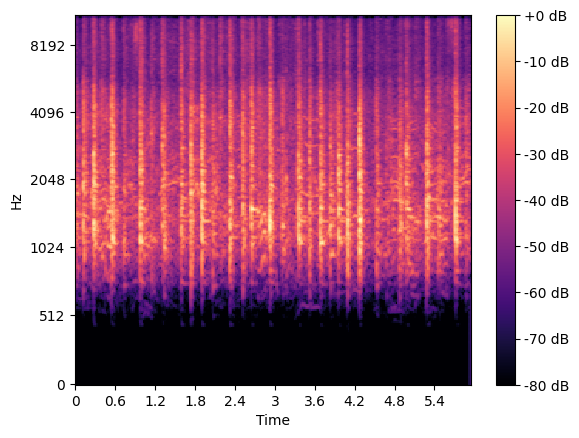

In [26]:

def spectro_work(id, high_freq = False):    
    #plt.rcParams["figure.figsize"] = [7.50, 3.50]
    #plt.rcParams["figure.autolayout"] = True

    fig, ax = plt.subplots()

    hl = 512 # number of samples per time-step in spectrogram
    hi = 256 # Height of image
    wi = 256 # Width of image

    # Loading demo track
    y, sr = librosa.load(soundPath(id))
    
    def get_high_freq(y, sr):
        b,a = signal.butter(10, 1000, btype='highpass', fs = sr)
        yf = signal.lfilter(b,a,y)
        return yf
    
    if high_freq:
        y = get_high_freq(y, sr)
    
    window = y[0:wi*hl]

    S = librosa.feature.melspectrogram(y=window, sr=sr, n_mels=hi, hop_length=hl)
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    plt.show()


spectro_work(19992, True)

In [1]:
y, sr = librosa.load(soundPath(19037))
print('Amlpitude Time Series:', y)
print('Size of series:',len(y))
print(f'Max amplitude: {np.max(y)}, Min amplitude: {np.min(y)}')

# b,a = signal.butter(10, 1000, btype='highpass', fs = sr)
# print (a)

# plt.plot(y)
# plt.ylabel('Amplitude')
# plt.xlabel('Discrete time')
# plt.show()

def get_high_freq(y, sr):
    b,a = signal.butter(10, 1000, btype='highpass', fs = sr)
    yf = signal.lfilter(b,a,y)
    return yf
yf = get_high_freq(y,sr)

NameError: name 'librosa' is not defined

In [ ]:

time1 = time.time()
x = librosa.stft(yf)
Xdb = librosa.amplitude_to_db(abs(x))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
print(time.time()-time1)

In [63]:
df = pd.read_csv('/kaggle/input/bird-voice-detection/metadata.csv')
true_labels = df.sample(10)
matrix = []

sum_time = 0
for i in true_labels['id'].tolist():
    time1 = time.time()
    pred = predict_audio(i,cnn7,True)
    t = time.time() - time1
    sum_time+=t
    true = true_labels.loc[true_labels['id']==i].iloc[0]['label']
    matrix.append([i, true, pred, t])
    
print(['id', 'true', 'predicted', 'time'])

for row in matrix:
    print(row)

print('Average time:', sum_time/10.0)

1/1 [==============================] - 0s 24ms/step
['id', 'true', 'predicted', 'time']
[166661, 0, 1, 0.8460690975189209]
[59200, 0, 1, 0.4536101818084717]
[111049, 1, 1, 0.4234893321990967]
[111737, 0, 1, 0.4477956295013428]
[73125, 0, 1, 0.43105220794677734]
[61987, 0, 0, 0.45757055282592773]
[86734, 0, 0, 0.43740129470825195]
[130483, 1, 1, 0.5143930912017822]
[2520, 0, 0, 0.44020986557006836]
[2527, 0, 0, 0.4234774112701416]
Average time: 0.4875068664550781


In [ ]:
conv1 = cnn.get_layer('conv2d_9')
# x1w = conv1.get_weights()[0][:,:,0,:]
# for i in range(1,26):
#     plt.subplot(5,5,i)
#     #plt.colorbar()
#     plt.imshow(x1w[:,:,i],interpolation="nearest",cmap="gray")
# plt.show()
conv1.get_weights()[0]

In [9]:
print(cnn.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_21 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_22 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 64)        18496     
                                                      

In [64]:
! pip freeze > requirements.txt